# Reinforcement Learning for Trading

In [31]:
import tensorflow as tf
import gym
import gym_anytrading

# basic libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

### Import Data
https://www.kaggle.com/datasets/jacksoncrow/stock-market-dataset?resource=download

In [32]:
df = pd.read_csv('stockdata/stocks/A.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1999-11-18,32.546494,35.765381,28.612303,31.473534,27.068665,62546300
1,1999-11-19,30.713520,30.758226,28.478184,28.880543,24.838577,15234100
2,1999-11-22,29.551144,31.473534,28.657009,31.473534,27.068665,6577800
3,1999-11-23,30.400572,31.205294,28.612303,28.612303,24.607880,5975600
4,1999-11-24,28.701717,29.998211,28.612303,29.372318,25.261524,4843200
...,...,...,...,...,...,...,...
5119,2020-03-26,70.000000,74.449997,69.650002,73.720001,73.532867,3267500
5120,2020-03-27,71.550003,73.209999,70.279999,70.910004,70.730003,1829800
5121,2020-03-30,71.059998,73.180000,71.059998,72.669998,72.669998,1486200
5122,2020-03-31,72.339996,72.800003,70.500000,71.620003,71.620003,1822100


In [33]:
#convert date to date
df['Date'] = pd.to_datetime(df['Date'])
df.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [34]:
# set date as index
df.set_index('Date', inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-11-18,32.546494,35.765381,28.612303,31.473534,27.068665,62546300
1999-11-19,30.713520,30.758226,28.478184,28.880543,24.838577,15234100
1999-11-22,29.551144,31.473534,28.657009,31.473534,27.068665,6577800
1999-11-23,30.400572,31.205294,28.612303,28.612303,24.607880,5975600
1999-11-24,28.701717,29.998211,28.612303,29.372318,25.261524,4843200


### Build Environment

In [35]:
#create environment
env = gym.make('stocks-v0', df=df, frame_bound=(5,100), window_size=5)

info {'total_reward': 21.738634109497085, 'total_profit': 1.020097733267485, 'position': 1}


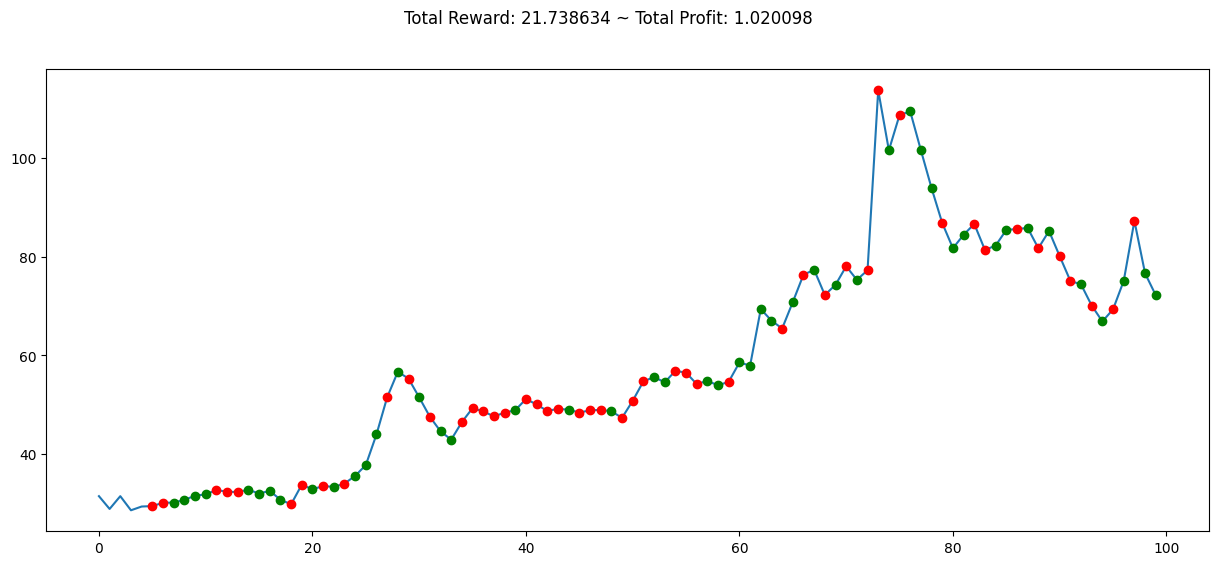

In [36]:
# show trendline
state = env.reset()
while True: 
    action = env.action_space.sample()
    n_state, reward, done, info = env.step(action)
    if done: 
        print("info", info)
        break
        
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

In [37]:
env_maker = lambda: gym.make('stocks-v0', df=df, frame_bound=(5,100), window_size=5)
env = DummyVecEnv([env_maker])

NameError: name 'DummyVecEnv' is not defined

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:

class A2C:
    def __init__(self, policy_type, env, verbose=1):
        self.policy_type = policy_type
        self.env = env
        self.verbose = verbose

        # Hyperparameters
        self.lr_actor = 0.001
        self.lr_critic = 0.001
        self.gamma = 0.6
        self.n_steps = 7
        self.batch_size = 64

        # Create the model and optimizers
        self.actor, self.critic = self.build_models()
        self.actor_optimizer = Adam(learning_rate=self.lr_actor)
        self.critic_optimizer = Adam(learning_rate=self.lr_critic)

    def build_models(self):
        obs_shape = self.env.observation_space.shape
        num_actions = self.env.action_space.n

        inputs = Input(shape=obs_shape)
        if self.policy_type == 'MlpLstmPolicy':
            x = Dense(64, activation='relu')(inputs)
            x = LSTM(64, activation='relu')(x)
        else:
            raise ValueError("Unknown policy type: {}".format(self.policy_type))

        actor_output = Dense(num_actions, activation='softmax')(x)
        critic_output = Dense(1)(x)

        actor = Model(inputs=inputs, outputs=actor_output)
        critic = Model(inputs=inputs, outputs=critic_output)

        return actor, critic

    def choose_action(self, state, epsilon=0.3):
        if np.random.rand() < epsilon:
            return np.random.choice(self.env.action_space.n)
        state = np.expand_dims(state, axis=0)
        action_probs = self.actor.predict(state)[0]
        action = np.random.choice(len(action_probs), p=action_probs)
        return action

    def compute_returns(self, rewards, dones, next_value):
        n = len(rewards)
        returns = np.zeros(n)
        prev_return = next_value

        for t in reversed(range(n)):
            returns[t] = rewards[t] + self.gamma * prev_return * (1 - dones[t])
            prev_return = returns[t]

        return returns
    
    def calculate_reward(self, portfolio_values):
        return portfolio_values[-1] - portfolio_values[0]

    def train(self, num_epochs):
        state = self.env.reset()
        episode_rewards = []
        for epoch in range(num_epochs):
            states, actions, rewards, dones, next_states = [], [], [], [], []

            for _ in range(self.n_steps):
                action = self.choose_action(state)
                next_state, reward, done, _ = self.env.step(action)

                states.append(state)
                actions.append(action)
                rewards.append(reward)
                dones.append(done)
                next_states.append(next_state)

                state = next_state

                if done:
                    state = self.env.reset()
                    episode_rewards.append(np.sum(rewards))

            #episode_reward = self.calculate_reward(self.env.portfolio_value)

            next_value = self.critic.predict(np.array(next_states))[-1][0]

            returns = self.compute_returns(rewards, dones, next_value)

            states = np.array(states)
            actions = np.array(actions)
            returns = np.array(returns)

            # Train actor and critic networks
            with tf.GradientTape(persistent=True) as tape:
                actor_probs = self.actor(states)
                actions_mask = tf.one_hot(actions, self.env.action_space.n)
                log_probs = tf.reduce_sum(actions_mask * tf.math.log(actor_probs), axis=1)
                actor_loss = -tf.reduce_mean(log_probs * (returns - self.critic(states)))

                critic_values = self.critic(states)
                critic_loss = tf.reduce_mean(tf.square(returns - tf.squeeze(critic_values)))

            actor_gradients = tape.gradient(actor_loss, self.actor.trainable_variables)
            critic_gradients = tape.gradient(critic_loss, self.critic.trainable_variables)

            self.actor_optimizer.apply_gradients(zip(actor_gradients, self.actor.trainable_variables))
            self.critic_optimizer.apply_gradients(zip(critic_gradients, self.critic.trainable_variables))

            if self.verbose > 0 and epoch % 10 == 0:
                mean_reward = np.mean(episode_rewards[-10:])
                print("Epoch: {} - Mean Reward: {:.2f}".format(epoch, mean_reward))

        if self.verbose > 0:
            final_mean_reward = np.mean(episode_rewards[-10:])
            print("Final Mean Reward: {:.2f}".format(final_mean_reward))

In [ ]:
model = A2C('MlpLstmPolicy', env, verbose=1) 
model.train(num_epochs=50)

1/1 [==============================] - 1s 597ms/step
Epoch: 0 - Mean Reward: nan
1/1 [==============================] - 0s 48ms/step


c:\Users\pischl\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\pischl\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1/1 [==============================] - 0s 54ms/step
Epoch: 10 - Mean Reward: nan
1/1 [==============================] - 0s 79ms/step
Epoch: 20 - Mean Reward: 7.29
1/1 [==============================] - 0s 101ms/step
Epoch: 30 - Mean Reward: 6.53
1/1 [==============================] - 0s 66ms/step
Epoch: 40 - Mean Reward: 4.35
1/1 [==============================] - 0s 53ms/step
Final Mean Reward: 4.35


In [ ]:
# Führe den Agenten in der Umgebung aus
state = env.reset()
done = False
total_reward = 0

while not done:
    action = model.choose_action(state)
    next_state, reward, done, _ = env.step(action)
    total_reward += reward
    state = next_state

print("Gesamte Belohnung: ", total_reward)

1/1 [==============================] - 0s 53ms/step
Gesamte Belohnung:  0.0894165039062429


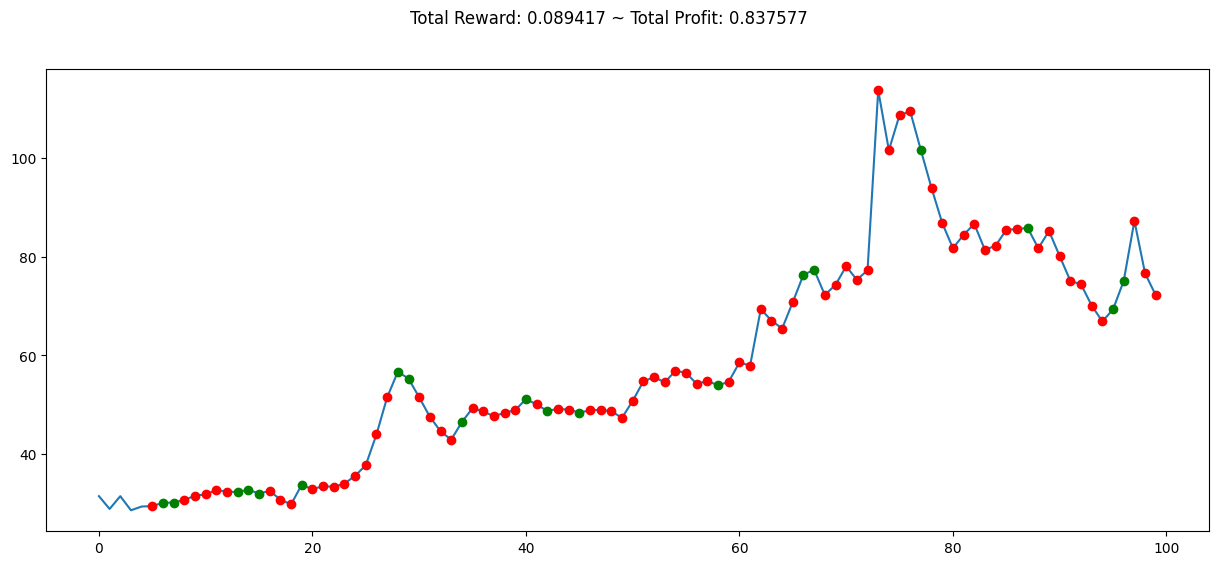

In [ ]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()